# Figure 3: Adding model predictors for modulatory inputs

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, randomized_svd
import statsmodels
from statsmodels.stats.multitest import multipletests
from statannotations.Annotator import Annotator

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from utils import *

In [3]:
color_dict = get_color_dict(color_names=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'lightblue'])

# Load data

In [4]:
data = pd.read_csv('../data/performance_data.csv')  

In [5]:
data_population = pd.read_csv('../data/population_data.csv')  

# Fetch data

In [6]:
data_set = 'test'

# Performance comparison all configs
sort_values = True
config_colors = ['#949494', '#0173b2', '#029e73', '#de8f05', '#56b4e9', '#fbafe4', '#d55e00', 'k']
config_names = ['Stimulus only', 'Stim.+Opto', 'Stim.+Run', 'Stim.+Eye', 'Stim.+Opto+Run', 'Stim.+Opto+Eye', 'Stim.+Run+Eye', 'Full model']
if sort_values==True:
    config_r_means = []
    for i in range(len(config_names)):
        config_r_means.append(np.mean(data[data['config_name'] == config_names[i]]['r_{:s}'.format(data_set)].values))
    idxs_sorted_idxs = np.array(config_r_means).argsort()
else:
    idxs_sorted_idxs = np.arange(config_names.shape[0])
# Create input config matrix for plotting
input_config = []
for config_name in config_names:
    input_config.append((data[data['config_name']==config_name].iloc[0][['config_stim', 'config_opto', 'config_run', 'config_eye']].values).astype(np.int))
input_config = np.vstack(input_config)
input_config = input_config[np.flip(idxs_sorted_idxs)[::-1]]    
        
# 'Stimulus only' vs. 'Full model' scatter colored by MIs
r_test_stim_only = data[data['config_name']=='Stimulus only']['r_{:s}'.format(data_set)].values
r_test_full_model = data[data['config_name']=='Full model']['r_{:s}'.format(data_set)].values
omis = data[data['config_name']=='Stimulus only']['omi'].values
rmis = data[data['config_name']=='Stimulus only']['rmi'].values
emis = data[data['config_name']=='Stimulus only']['emi'].values
mis = 1-(1-abs(omis))*(1-abs(rmis))*(1-abs(emis))
mi_names = ['omi', 'rmi', 'emi', 'mi']
mi_vals = [omis, rmis, emis, mis]
mi_labels = ['MI$_{CT~FB~supp.}$', 'MI$_{Run}$', 'MI$_{Pupil}$', 'MI$_{Joint}$']

### Significance test

In [7]:
pvals = []
r_stim_only = data[data['config_name']=='Stimulus only']['r_test'].values
for config_name in config_names[1:]:
    r_compare = data[data['config_name']==config_name]['r_test'].values
    stats, pval = scipy.stats.wilcoxon(r_stim_only, r_compare, alternative='two-sided')
    pvals.append(pval)
pvals = np.array(pvals)
reject, pvals_corrected, alphacSidak, alphacBonf = statsmodels.stats.multitest.multipletests(pvals, alpha=0.05, method='bonferroni')

for i, config_name in enumerate(config_names[1:]):
    print(config_name)
    print('\t'+str(pvals_corrected[i]))

# Format p-values for plotting
formatted_pvalues = []
for p in pvals_corrected:
    formatted_pvalues.append(get_formatted_pval(p, stars=True, show_ns_val=False))
    
# Select pairs
pairs=[('Stimulus only', 'Stim.+Opto'),
       ('Stimulus only', 'Stim.+Eye'),
       ('Stimulus only', 'Full model'),
      ]
formatted_pvalues_plot = []
for pair in pairs:
    position = config_names[1:].index(pair[1])
    formatted_pvalues_plot.append(np.array(formatted_pvalues)[position])

Stim.+Opto
	0.546876352277542
Stim.+Run
	0.0907540586833929
Stim.+Eye
	3.3966034701451153e-06
Stim.+Opto+Run
	0.0001046425047642577
Stim.+Opto+Eye
	3.45817540711574e-10
Stim.+Run+Eye
	1.1617422202340082e-06
Full model
	2.0805889970269197e-07


### ANOVA

In [8]:
samples = []
for config_name in config_names:
    samples.append(data[data['config_name']==config_name]['r_test'].values)

In [9]:
f_val, p_val = scipy.stats.f_oneway(*samples)

print('ANOVA')
print(f'p = {p_val}')
print(f'F = {f_val}')

ANOVA
p = 0.00267758167849888
F = 3.15126157657059


# Plotting

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Stimulus only vs. Stim.+Opto: ns
Stimulus only vs. Stim.+Eye: ****
Stimulus only vs. Full model: ****


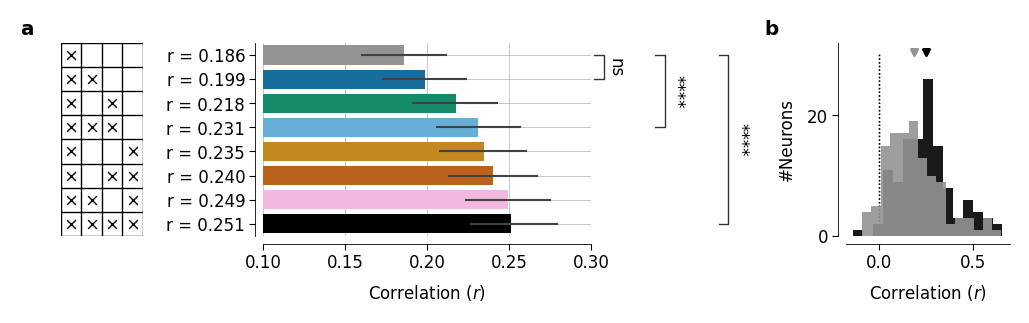

In [10]:
with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    abc
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(5, 1.5),
        dpi=200,
        constrained_layout=True,
        gridspec_kw={"width_ratios":[.25, 1, .5]},
    )

    txt_kwargs = dict(
        color="black", fontsize="larger"
    )
    
    ax = ax_dict['a'] 
    ax.scatter(np.where(input_config==1)[1], np.where(input_config==1)[0], marker='x', color='k', s=10)
    for x_vline in np.arange(-.5, 4, 1):
        ax.axvline(x_vline, color='k')
    for h_vline in np.arange(-.5, 8, 1):
        ax.axhline(h_vline, color='k')
    ax.set_xlim([-.5, 3.5])
    ax.set_ylim([-.5, 7.5])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_title('a', loc="left", **txt_kwargs, x=-.5, fontweight='bold')
    
    # All configs- performance
    ax = ax_dict['b'] 
    ax = sns.barplot(y='config_name', 
                     x='r_{:s}'.format(data_set), 
                     data=data, 
                     ci=95,
                     palette=np.array(config_colors)[idxs_sorted_idxs], 
                     errwidth=.75, 
                     orient='h',
                     order=np.array(config_names)[idxs_sorted_idxs],
                     zorder=1,
                     ax=ax)    
    # Pearson r on the side
    cnfgs = np.array(config_names)[idxs_sorted_idxs]
    r_configs = []
    for i, cnfg in enumerate(cnfgs):
        r_cnfg = np.mean(data[data['config_name']==cnfg]['r_{:s}'.format(data_set)].values)
        r_configs.append('r = {:.3f}'.format(r_cnfg))
    ax.set_yticklabels(r_configs, fontdict={'color':'white'}, alpha=0.0)
    # Annotations
    annotator = Annotator(ax=ax, 
                          pairs=pairs, 
                          data=data, 
                          y="config_name", 
                          x='r_{:s}'.format(data_set), 
                          order=None, 
                          orient='h',
                          short_test_name=False)
    annotator.set_custom_annotations(formatted_pvalues_plot)
    annotator.configure(loc='outside', fontsize=6, line_width=.5)
    annotator.annotate()
    # Axis
    ax.set_xlim(.1,.3)
    ax.set_xticks(np.arange(0.1, .35, 0.05))
    ax.set_axisbelow(True)
    ax.grid(lw=.25, zorder=0)
    ax.set_xlabel('Correlation ($r$)')
    ax.set_ylabel('')
    ax.set_title('', loc="left", **txt_kwargs, x=0)
    
    
    # Stim.-only model vs. Full model
    ax = ax_dict['c'] 
    configs = ['Full model', 'Stimulus only']
    for config in configs:
        r_test = data[data['config_name']==config]['r_test'].values
        color = data[data['config_name']==config]['config_color'].values[0]
        ax.hist(r_test, edgecolor='none', facecolor=color, bins=15, zorder=1, alpha=.9)
        ax.scatter(np.mean(r_test), r_test.shape[0]/4, color=color, marker='v', s=5)
        ax.vlines(x=0, ymin=0, ymax=r_test.shape[0]/4, color='k', linestyle=':', lw=.5, zorder=0)
    ax.set_title('b', loc="left", **txt_kwargs, x=-.5, fontweight='bold')
    ax.set_ylabel('#Neurons')
    ax.set_xlabel('Correlation ($r$)')
    
    sns.despine(offset=3)
    
    ax=ax_dict['a']
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.invert_yaxis()

### 'Stimulus only' model vs. 'Full model'

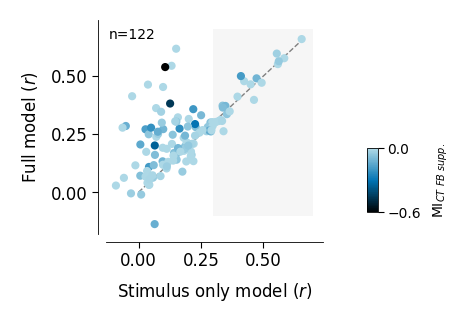

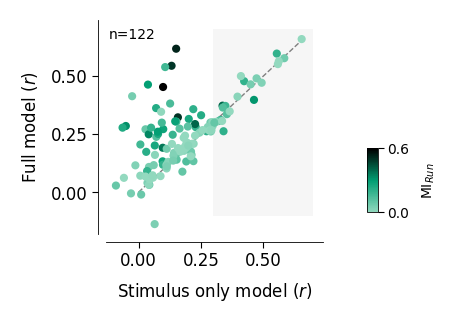

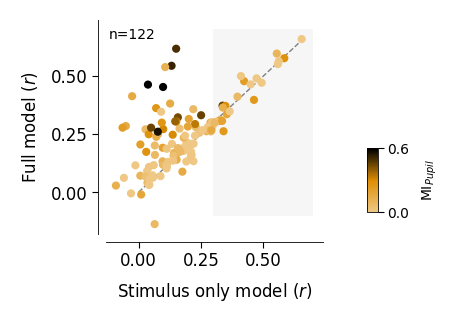

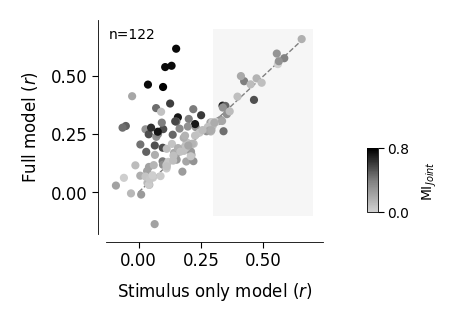

In [11]:
plt.style.use("matplotlib_config.txt")
txt_kwargs = dict(color="black", fontsize="larger")
for i in range(4):
    fig, ax = plt.subplots(figsize=(1.6, 1.5), dpi=200, constrained_layout=True)
    
    if mi_names[i] == 'omi':
        colors_cmap = ['k', color_dict['blue'], 'lightblue']
        vmin = -.6
        vmax = 0
    elif mi_names[i] == 'rmi':
        colors_cmap = ['#93d9bfff', color_dict['green'], 'k']
        vmin = 0
        vmax = .6
    elif mi_names[i] == 'emi':
        colors_cmap = ['#efc886ff', color_dict['orange'], 'k']
        vmin = 0
        vmax = .6
    elif mi_names[i] == 'mi':
        colors_cmap = ['lightgray', 'gray', 'k']
        vmin = 0
        vmax = .8
    
    cmap = LinearSegmentedColormap.from_list(mi_names[i], colors_cmap, N=100)
    im = ax.scatter(r_test_stim_only, r_test_full_model, c=mi_vals[i], cmap=cmap, vmin=vmin, vmax=vmax, s=15, zorder=1)
    ax.plot([0, .65], [0, .65], lw=.5, color='gray', linestyle='--', zorder=0)
    ax.fill_between(x=[.3, .7], y1=-.1, y2=.7, edgecolor='none', facecolor='lightgray', alpha=.2, zorder=0)
    ax.set_xticks(np.arange(0, .7, .25))
    ax.set_yticks(np.arange(0, .6, .25))
    ax.set_xlabel('Stimulus only model ($r$)')
    ax.text(s='n={:d}'.format(r_test_stim_only.shape[0]), x=-.12, y=r_test_full_model.max(), fontsize=5)
    ax.set_title('', loc="left", **txt_kwargs, x=-.4, fontweight='bold')
    ax.set_ylabel('Full model ($r$)')
    
    # Colorbar
    axins = inset_axes(ax, width="5%", height="30%", loc="lower right",
                       bbox_to_anchor=(.25, .1, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
    cbar = fig.colorbar(im, cax=axins, orientation='vertical', ticks=[vmin, vmax])
    cbar.ax.tick_params(labelsize=5)
    cbar.set_label(mi_labels[i], fontsize=5)
    
    sns.despine(offset=3)
    axins.spines['left'].set_visible(False)
    axins.spines['bottom'].set_visible(False)

# 'Modulation only' models

In [12]:
data_set = 'test'

# Performance comparison all configs
sort_values = True
config_colors = data['config_color'].unique()
config_names = data['config_name'].unique()
if sort_values==True:
    config_r_means = []
    for i in range(len(config_names)):
        config_r_means.append(np.mean(data[data['config_name'] == config_names[i]]['r_mean_{:s}'.format(data_set)].values))
    idxs_sorted_idxs = np.array(config_r_means).argsort()
else:
    idxs_sorted_idxs = np.arange(config_names.shape[0])
# Create input config matrix for plotting
input_config = []
for config_name in config_names:
    input_config.append(np.hstack((np.array([True]), (data[data['config_name']==config_name].iloc[0][['config_opto', 'config_run', 'config_eye']].values))).astype(np.int))
input_config = np.vstack(input_config)
input_config = input_config[np.flip(idxs_sorted_idxs)[::-1]]    
        
# 'Stimulus only' vs. 'Full model' scatter colored by MIs
r_test_stim_only = data[data['config_name']=='Stimulus only']['r_{:s}'.format(data_set)].values
r_test_full_model = data[data['config_name']=='Full model']['r_{:s}'.format(data_set)].values
r_test_improvement = r_test_full_model-r_test_stim_only
r_test_full_noStim = data[data['config_name']=='noStim_Full model']['r_{:s}'.format(data_set)].values

omis = data[data['config_name']=='Stimulus only']['omi'].values
rmis = data[data['config_name']=='Stimulus only']['rmi'].values
emis = data[data['config_name']=='Stimulus only']['emi'].values
mis = 1-(1-abs(omis))*(1-abs(rmis))*(1-abs(emis))
mi_names = ['omi', 'rmi', 'emi', 'mi']
mi_vals = [omis, rmis, emis, mis]
mi_labels = ['MI$_{opto}$', 'MI$_{run}$', 'MI$_{eye}$', 'Non-retinal\nmodulation']

In [13]:
# Split into modulation sensitive vs. Stimulus explained neurons
thresh_improvement = .3
df_group_plt = pd.DataFrame(dict(r_test_full_model=r_test_full_model,
                                 r_test_stim_only=r_test_stim_only,
                                 r_test_full_noStim=r_test_full_noStim,
                                 improvement=r_test_improvement,
                                 group=np.hstack([['low']*40, ['medium']*40, ['high']*42]),
                                 mi=mis,
                                 omi=omis,
                                 rmi=rmis,
                                 emi=emis,
                                 ))
bool_improvement=np.array(['no']*r_test_full_model.shape[0])#np.zeros(r_test_full_model.shape)
bool_improvement[(df_group_plt[df_group_plt['improvement']>thresh_improvement]).index]='yes'
df_group_plt['bool_improvement']=bool_improvement

corrcoeff_improvement_mi, pval_improvement_mi = scipy.stats.pearsonr(df_group_plt['improvement'].values, df_group_plt['mi'].values)
pval_improvement_mi_star = get_formatted_pval(pval_improvement_mi, stars=True, show_ns_val=False)

In [14]:
pairs=[('low', 'medium'),
       ('low', 'high'),
       ]

# Stats
pvals = []
for pair in pairs:
    x = df_group_plt[df_group_plt['group']==pair[0]]['improvement'].values
    y = df_group_plt[df_group_plt['group']==pair[1]]['improvement'].values
    stats, pval = scipy.stats.mannwhitneyu(x, y, alternative='two-sided')
    pvals.append(pval)
pvals = np.array(pvals)
reject, pvals_corrected, alphacSidak, alphacBonf = statsmodels.stats.multitest.multipletests(pvals, alpha=0.05, method='bonferroni')

# Format p-values for plotting
formatted_pvalues = []
for p in pvals_corrected:
    formatted_pvalues.append(get_formatted_pval(p, stars=True, show_ns_val=False))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. medium: *
low vs. high: ****


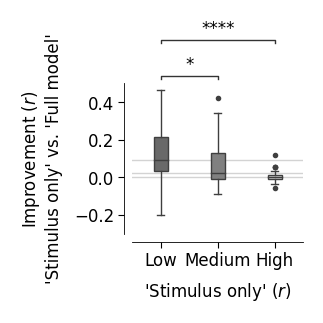

In [15]:
with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    a
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(1.5, 1.5),
        dpi=200,
        constrained_layout=True,
    )

    txt_kwargs = dict(
        color="black", fontsize="larger"
    )

    ax = ax_dict['a'] 
    sns.boxplot(data=df_group_plt,
                y='improvement',
                x='group',
                ax=ax,
                palette=['dimgray', 'gray', 'lightgray'],
                width=.25,
                fliersize=2,
                flierprops={"marker": "."},
                zorder=5,
               )
    ax.axhline(y=np.median(df_group_plt[df_group_plt['group']=='low']['improvement'].values), linestyle='-', color='lightgray', zorder=0)
    ax.axhline(y=np.median(df_group_plt[df_group_plt['group']=='medium']['improvement'].values), linestyle='-', color='lightgray', zorder=0)
    ax.axhline(y=np.median(df_group_plt[df_group_plt['group']=='high']['improvement'].values), linestyle='-', color='lightgray', zorder=0)
    ax.set_ylim([-.3,.5])
    ax.set_xticklabels(['Low', 'Medium', 'High'])
    
    ax.set_xlabel("'Stimulus only' ($r$)")
    ax.set_ylabel("Improvement ($r$)\n'Stimulus only' vs. 'Full model'")
    
    # Annotations
    annotator = Annotator(ax=ax, 
                          pairs=pairs, 
                          data=df_group_plt, 
                          y='improvement',
                          x='group',
                          order=None, 
                          orient='v',
                          short_test_name=False)
    annotator.set_custom_annotations(formatted_pvalues)
    annotator.configure(loc='outside', fontsize=6, line_width=.5)
    annotator.annotate()    

    sns.despine(offset=3, trim=False)

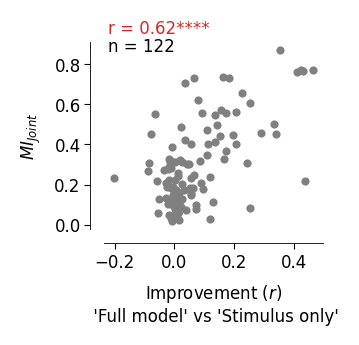

In [16]:
colors_cmap = ['lightgray', 'gray', 'k']
cmap = LinearSegmentedColormap.from_list('mi', colors_cmap, N=100)

with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    a
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(1.6, 1.5),
        dpi=200,
        constrained_layout=True,
    )

    txt_kwargs = dict(
        color="black", fontsize="larger"
    )
    ax = ax_dict['a'] 
    im = ax.scatter(df_group_plt['improvement'].values, df_group_plt['mi'].values, color='gray', vmin=0, vmax=.8, s=15, zorder=1)#c=df_group_plt['mi'].values
    ax.set_ylabel('$MI_{Joint}$')
    ax.set_xlabel("Improvement ($r$)\n 'Full model' vs 'Stimulus only'")

    sns.despine(trim=False, offset=5)

    fig.text(s=f"r = {corrcoeff_improvement_mi:.2f}{pval_improvement_mi_star}", y=1.0, x=.3, color='tab:red')
    fig.text(s=f"n = {df_group_plt.shape[0]}", y=.94, x=.3)

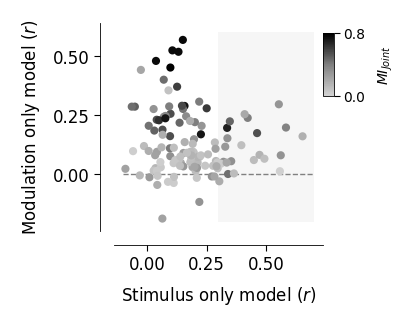

In [17]:
colors_cmap = ['lightgray', 'gray', 'k']
cmap = LinearSegmentedColormap.from_list('mi', colors_cmap, N=100)

with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    a
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(1.6, 1.5),
        dpi=200,
        constrained_layout=True,
    )

    txt_kwargs = dict(
        color="black", fontsize="larger"
    )
    ax = ax_dict['a'] 
    ax.plot([-.1,.7], [0, 0], linestyle='--', color='gray', zorder=0)
    im = ax.scatter(x=df_group_plt['r_test_stim_only'].values, 
                    y=df_group_plt['r_test_full_noStim'].values,
                    c=df_group_plt['mi'],
                    cmap=cmap,
                    vmin=0,
                    vmax=.8,
                    s=15,
                   )
    ax.set_xticks([0,.25, .5])
    ax.set_yticks([0,.25, .5])

    # Colorbar
    axins = inset_axes(ax, width="5%", height="30%", loc="lower right",
                       bbox_to_anchor=(.05, .65, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
    ax.fill_between(x=[.3, .7], y1=-.2, y2=.6, edgecolor='none', facecolor='lightgray', alpha=.2, zorder=0)
    cbar = fig.colorbar(im, cax=axins, orientation='vertical', ticks=[0, .8])
    cbar.ax.tick_params(labelsize=5)
    cbar.set_label('$MI_{Joint}$', fontsize=5)

    ax.set_xlabel("Stimulus only model ($r$)")
    ax.set_ylabel('Modulation only model ($r$)')

    sns.despine(trim=False, offset=5)